In [1]:
import numpy as np
import pandas as pd

# preprocessing 
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
import string
import gensim  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # bags of words and TF IDF

#split dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold # For stratified splitting (helpful in imbalanced data)
from sklearn.preprocessing import MultiLabelBinarizer 

# analyze result
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix , make_scorer
# cnn
from keras.layers.regularization.dropout import Dropout
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D

# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Exploratory analysis of data
data=pd.read_csv("/content/data.csv",encoding='unicode_escape')
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [4]:
data=data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5836 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5836 non-null   object
 1   Sentiment  5836 non-null   object
dtypes: object(2)
memory usage: 136.8+ KB


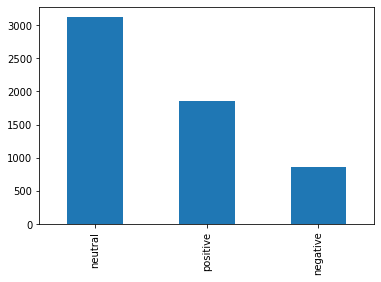

In [5]:
data.Sentiment.value_counts().plot.bar()

In [6]:
# Data preprocessing

# with removal of stopwords

stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    text_tokenize = re.split('\W+', text)
    text_nostop = [word for word in text_tokenize if word not in stopwords]
    #text_stemm = [ps.stem(x) for x in text_nostop]
    text_lemm = [wn.lemmatize(x) for x in text_nostop]
    return text_lemm

def clean_text_nostop(text):
    text = "".join([word for word in text if word not in string.punctuation])
    text_tokenize = re.split('\W+', text)
    text_lemm = [wn.lemmatize(x) for x in text_tokenize]
    return text_lemm    

data['text_clean'] = data['Sentence'].apply(lambda x: clean_text(x.lower()))
data['text_clean_nostop'] = data['Sentence'].apply(lambda x: clean_text_nostop(x.lower()))
data.head()


,Sentence,Sentiment,text_clean,text_clean_nostop
0,The GeoSolutions technology will leverage Bene...,positive,"[geosolutions, technology, leverage, benefon, ...","[the, geosolutions, technology, will, leverage..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,"[esi, low, 150, 250, bk, real, possibility]","[esi, on, low, down, 150, to, 250, bk, a, real..."
2,"For the last quarter of 2010 , Componenta 's n...",positive,"[last, quarter, 2010, componenta, net, sale, d...","[for, the, last, quarter, of, 2010, componenta..."
3,According to the Finnish-Russian Chamber of Co...,neutral,"[according, finnishrussian, chamber, commerce,...","[according, to, the, finnishrussian, chamber, ..."
4,The Swedish buyout firm has sold its remaining...,neutral,"[swedish, buyout, firm, sold, remaining, 224, ...","[the, swedish, buyout, firm, ha, sold, it, rem..."


In [7]:
#labeling target variable
dict_label= {'positive': 0, 'neutral': 0 , 'negative': 1}
data.Sentiment = data.Sentiment.map(dict_label)
#one hot encoding of label for cnn
y_ohe = pd.get_dummies(data['Sentiment'])

In [14]:
# CLASSIFFIERS

#model_1- Logistic Regression 

def LogReg_bow_tfidf_ngram(data = data,bow = False,TFIDF = False,Ngram = False, stopw=False):
  X = data.sample(frac=1).reset_index(drop= True) # this shuffle data and reset index
  y = data.Sentiment.values
  if bow and stopw:
        count_vec = CountVectorizer(tokenizer = word_tokenize, analyzer=clean_text,token_pattern=None)
  elif TFIDF and stopw:
      count_vec = TfidfVectorizer(tokenizer = word_tokenize, analyzer=clean_text,token_pattern=None)
  elif Ngram and stopw:
      count_vec = CountVectorizer(tokenizer = word_tokenize,analyzer=clean_text, token_pattern=None, ngram_range = (1, 3))
  elif bow:  
       count_vec = CountVectorizer(tokenizer = word_tokenize, analyzer=clean_text_nostop,token_pattern=None)
  elif TFIDF:
       count_vec = TfidfVectorizer(tokenizer = word_tokenize, analyzer=clean_text_nostop,token_pattern=None)
  elif Ngram: 
      count_vec = CountVectorizer(tokenizer = word_tokenize,analyzer=clean_text_nostop, token_pattern=None, ngram_range = (1, 3))   
    
  model=LogisticRegression(solver = 'liblinear')
  skf = StratifiedKFold(n_splits=5)
  lst_accu_stratified=[]
  for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        
        X_train=X.iloc[train_index,:]
        X_test=X.iloc[test_index,:]
        y_train=y[train_index]
        y_test=y[test_index]

        Xtrain_countVec = count_vec.fit_transform(X_train['Sentence'])
        Xtest_countVec = count_vec.transform(X_test['Sentence'])
        
        model.fit(Xtrain_countVec,y_train)
        y_pred = model.predict(Xtest_countVec)
        accuracy_precision = precision_score(y_test, y_pred, average='micro')
        accuracy_recall = recall_score(y_test, y_pred, average='micro')
        lst_accu_stratified.append([accuracy_precision,accuracy_recall])

        #print('precision score:', accuracy_precision)
        #print('recall score:', accuracy_recall)
        #print("========================================================")
  print('Overall precision and recall:',np.mean(lst_accu_stratified,axis=0))
        

In [15]:
# Logistic Regression+ BOW+ text without stopwords
LogReg_bow_tfidf_ngram(data = data,bow = True,TFIDF = False,Ngram = False,stopw=True)
# Logistic Regression+ TFIDF+ text without stopwords
LogReg_bow_tfidf_ngram(data = data,bow = False,TFIDF = True,Ngram = False,stopw=True)
# Logistic Regression+ Ngram=3+ text without stopwords
LogReg_bow_tfidf_ngram(data = data,bow = False,TFIDF = False,Ngram = True,stopw=True)

Overall precision and recall: [0.83019186 0.83019186]
Overall precision and recall: [0.85263878 0.85263878]
Overall precision and recall: [0.8300199 0.8300199]


In [16]:
# Logistic Regression+ BOW+ text with stopwords
LogReg_bow_tfidf_ngram(data = data,bow = True,TFIDF = False,Ngram = False)
# Logistic Regression+ TFIDF+ text with stopwords
LogReg_bow_tfidf_ngram(data = data,bow = False,TFIDF = True,Ngram = False)
# Logistic Regression+ Ngram=3+ text with stopwords
LogReg_bow_tfidf_ngram(data = data,bow = False,TFIDF = False,Ngram = True)

Overall precision and recall: [0.83430556 0.83430556]
Overall precision and recall: [0.85263878 0.85263878]
Overall precision and recall: [0.83087635 0.83087635]


In [28]:
#model_2- Naive Bayes


X = data.sample(frac=1).reset_index(drop= True) # this shuffle data and reset index
y = data.Sentiment.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0)
# text without stopword
cv=CountVectorizer(analyzer=clean_text)
Xtrain_cv = cv.fit_transform(X_train['Sentence'])
Xtest_cv = cv.transform(X_test['Sentence'])

classifier1=GaussianNB()
classifier1.fit(Xtrain_cv.toarray(),y_train)
y_pred=classifier1.predict(Xtest_cv.toarray())
accuracy_precision = precision_score(y_test, y_pred, average='micro')
accuracy_recall = recall_score(y_test, y_pred, average='micro')
print('precision score:', accuracy_precision)
print('recall score:', accuracy_recall)
print("========================================================")
# text with stopword
cv=CountVectorizer(analyzer=clean_text_nostop)
Xtrain_cv = cv.fit_transform(X_train['Sentence'])
Xtest_cv = cv.transform(X_test['Sentence'])
classifier2=GaussianNB()
classifier2.fit(Xtrain_cv.toarray(),y_train)
y_pred=classifier2.predict(Xtest_cv.toarray())
accuracy_precision = precision_score(y_test, y_pred, average='micro')
accuracy_recall = recall_score(y_test, y_pred, average='micro')
print('precision score:', accuracy_precision)
print('recall score:', accuracy_recall)
print("========================================================")

precision score: 0.704592186429061
recall score: 0.704592186429061
precision score: 0.7059629883481837
recall score: 0.7059629883481837


In [29]:
#model_3- Random Forest
X_train,X_test,y_train,y_test=train_test_split(data['text_clean'],data['Sentiment'],test_size=0.25)
w2v_model=gensim.models.Word2Vec(X_train,min_count=1)# Word 2 Vector
vecWords=w2v_model.wv.index2word
X_train_vect=np.array([np.array([w2v_model.wv[i] for i in ls if i in vecWords]) for ls in X_train])
X_test_vect=np.array([np.array([w2v_model.wv[i] for i in ls if i in vecWords]) for ls in X_test])

X_train_vect_avg=[]
for v in X_train_vect:
  if v.size:
    X_train_vect_avg.append(v.mean(axis=0))
  else:
      X_train_vect_avg.append(np.zeros(100,dtype=float))

X_test_vect_avg=[]
for v in X_test_vect:
  if v.size:
    X_test_vect_avg.append(v.mean(axis=0))
  else:
      X_test_vect_avg.append(np.zeros(100,dtype=float))

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train_vect_avg,y_train)
y_pred=clf.predict(X_test_vect_avg)
accuracy_precision = precision_score(y_test, y_pred, average='micro')
accuracy_recall = recall_score(y_test, y_pred, average='micro')
print('precision score:', accuracy_precision)
print('recall score:', accuracy_recall)
print("========================================================")          

precision score: 0.7909527073337903
recall score: 0.7909527073337903
